# **${\Large\text{Criptografía 2024-10 - Proyecto 2}}$**

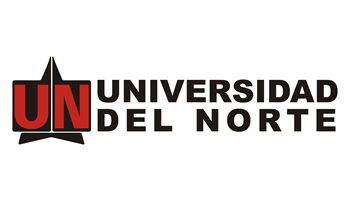

---

## **Nombre y Códigos de los Estudiantes:**
- Estudiante 1: Sonya Castro (200150166)
- Estudiante 2
- Estudiante 3
- Estudiante 4

## **Indicaciones:**

1. **El proyecto debe ser entregado a más tardar a las 11:59 p.m. del domingo 12 de mayo del 2024**, después de esto el enlace para enviar el proyecto se cerrará. Asegúrese de enviar el proyecto antes de la hora de finalización, no se aceptarán proyectos enviados por ningún otro medio.
2. El proyecto debe ser realizado en equipos de **4 integrantes**.
3. Cree una copia de este archivo de Google Colab.
4. Utilice la librería `pycryptodome` para el desarrollo del proyecto.
  - Puede instalarla ejecutando el siguiente código en una celda del archivo de Google Colab: `!pip install pycryptodome`.
5. Únicamente envíe el cuaderno de Jupyter con los códigos, las respuestas y el informe correspondiente.

## **Enunciado:**
El objetivo de este proyecto es intentar recuperar una serie de contraseñas que han sido almacenadas de manera segura utilizando 4 protocolos diferentes listados a continuación:
1. Protocolo de almacenamiento de contraseñas versión 1.
   - Se almacena `(username, H(password))`.
2. Protocolo de almacenamiento de contraseñas versión 2.
   - Se almacena `(username, salt, H(password || salt))`.
3. Protocolo de almacenamiento de contraseñas versión 3.
   - Se almacena `(username, salt, H(password || pepper || salt))`.
4. Protocolo de almacenamiento de contraseñas utilizando una PBKDF.
   - Se almacena `(username, salt, PBKDF(password, salt, 64, 2 ** 20, H))`.
     - `64` es el número de bytes que se obtentrán de la función `PBKDF`.
     - `2 ** 20` es la dificultad `d` de la función `PBKDF`.

En todos los escenarios anteriores la función hash `H` utilizada fue `SHA3_512` de `Crypto.Hash`. Para el último escenario la función PBKDF utilizada fue `PBKDF2` de `Crypto.Protocol.KDF`.

En cada escenario deberán obtener la contraseña para cada uno de los integrantes del grupo de trabajo utilizando como identificador el usuario Uninorte. Para ello, deberán utilizar el **archivo de contraseñas comunes** ([rockyou.txt](https://www.kaggle.com/datasets/wjburns/common-password-list-rockyoutxt)) provisto y la base de datos (archivo de contraseñas) correspondiente.

Se recomienda paralelizar el proceso de búsqueda de contraseñas para reducir el tiempo de ejecución.

Finalmente, se debe realizar un informe (puede ser en el mismo Jupyter Notebook / Google Colab) dónde:
1. Se expliquen los métodos / estrategias utilizados para obtener las contraseñas originales.
2. Se realice un análisis de los tiempos de ejecución de los métodos propuestos para la recuperación de las contraseñas.
3. Se realice un breve análisis de seguridad de los protocolos, contra un atacante que se robe la base de datos de las contraseñas. Adicionalmente, mencione cuál(es) protocolo(s) utilizaria usted para la protección de las contraseñas y por qué.
4. Se exponga y justifique los contratiempos y motivos en caso de no recuperar alguna de las contraseñas originales.

## Librerias

In [1]:
%pip install pycryptodome

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from time import time

from Crypto.Hash import SHA3_512
from Crypto.Protocol.KDF import PBKDF2

## Setup

In [3]:
usernames = ['sonyac', 'awperez', 'mhiguita', 'cleonard']

In [16]:
def H(data: str, salt: str = None, pepper: str = None) -> str:
  """Hash function using SHA3_512

  Args:
      data (str)
      salt (str, optional): Defaults to None.
      pepper (str, optional): Defaults to None.

  Returns:
      str: hashed data
  """
  
  h = SHA3_512.new(data=bytes(data, "utf-8"))

  if pepper != None: 
    h.update(bytes(pepper, "utf-8"))
  
  if salt != None: 
    h.update(bytes(salt, "utf-8"))

  return h.hexdigest()

In [17]:
def timer(f):
  def wrap(*args, **kwargs):
    t1 = time()
    result = f(*args, **kwargs)
    t2 = time()
    print(f'Function {f.__name__!r} executed in {(t2-t1):.4f}s')
    return result
  return wrap

## **Caso 1 (Protocolo V.1):**

In [6]:
filename = 'password_database_v1.csv'

In [7]:
db_v1 = pd.read_csv(f"data/{filename}")
db_v1 = db_v1[db_v1['username'].isin(usernames)]
db_v1

,username,password
6,cleonard,b1341f3768fe16d6867037c1dc57bb5d74995f3be86259...
7,sonyac,ab0dee66b5b53241f336d588014002cd849f8fed5f847d...
26,awperez,bb23702961eaf057dc60d64de843d9b00d01d07df59789...
34,mhiguita,b457ebd7121c0865af8b7f740f8f6b147a9571981deda2...


### **Método**: Ataque de diccionario

rockyou.txt contains 14,341,564 unique passwords, used in 32,603,388 accounts.

In [18]:
class DicctionaryAttack:
  
  def __init__(self) -> None:
    self.d = {}

  @timer
  def generate(self, filename: str):
    with open(filename, "r", encoding="ISO-8859-1") as plain_pwd:
      for plain in plain_pwd:
        plain = plain.strip()

        hash = H(plain)
        self.d[hash] = plain

  @timer
  def save(self, filename: str):
    with open(filename, 'w+', encoding="ISO-8859-1") as hash_pwd:
      for hash, pwd in self.d.items():
        hash_pwd.write(hash + "," + pwd + "\n")

  @timer
  def load(self, hash_filename: str):
    with open(hash_filename, "r", encoding="ISO-8859-1") as hash_pwd:
      for line in hash_pwd:
        hash, pwd = line.strip().split(",", 1)
        self.d[hash] = pwd

  @timer
  def find(self, hash):
    return self.d.get(hash, None)

In [10]:
attack = DicctionaryAttack(H)
attack.generate('./data/rockyou.txt')

Function 'generate' executed in 378.7280s


In [20]:
attack.save('./data/v1/screwyou.txt')

Function 'save' executed in 19.4660s


In [25]:
# Prueba
result = attack.find(H("pollito"))
assert(result == 'pollito'), f"Test failed. Expected pollito, got {result}."

Function 'find' executed in 0.0000s


### Resultados

In [27]:
for index, row in db_v1.iterrows():
    hash_pwd = row["password"]
    pwd = attack.find(hash_pwd)

    print(row["username"], pwd, "\n")
    assert(hash_pwd == H(pwd)), f"Test failed. Expected {hash_pwd}, got {H(pwd)}."    

Function 'find' executed in 0.0000s
cleonard 0923612667jfb 

Function 'find' executed in 0.0000s
sonyac shmily69 

Function 'find' executed in 0.0000s
awperez 19no583 

Function 'find' executed in 0.0008s
mhiguita camycarmen 



## **Caso 2 (Protocolo V.2):**

In [37]:
filename = 'password_database_v2.csv'

In [38]:
db_v2 = pd.read_csv(f"data/{filename}")
db_v2 = db_v2[db_v2['username'].isin(usernames)]
db_v2

,username,salt,password
6,cleonard,a81928e5f0f702f7cdcbba9ac96521c7,5c01545c628590a2d2072d314f5c3eef5d52afd40141f9...
7,sonyac,9561a9e469aaa3c065108e1dfeff0013,4608e8818ef3c4e30c04dc48b0c5ae8275bbad82bdd8b0...
26,awperez,a57380d3093d9a596a08b5fdee1cf414,5e5a576eb2c6d109ac0dd4cdde6e803238ae5e6159f5e0...
34,mhiguita,9ffd77ed58231bfabfdc0ceafe8b47c3,0e7cd1aea3597bde370e3fa47873480993a960bd1c98ea...


### **Método**: Ataque de diccionario con sal

In [41]:
class DicctionaryAttackWithSalt:

  def __init__(self) -> None:
    self.d = {}

  @timer
  def find(self, hash, salt, filename = 'data/rockyou.txt'):
    with open(filename, "r", encoding="ISO-8859-1") as plain_pwd:
      for pwd in plain_pwd:
        pwd = pwd.strip()
        if H(pwd, salt) == hash: 
          return pwd

Pre-test

In [42]:
_, salt, password = db_v2.iloc[1]

attack = DicctionaryAttackWithSalt()
result = attack.find(H('pollito', salt), salt)
assert(result == 'pollito')

Function 'find' executed in 0.0205s


### Resultados

In [43]:
for index, row in db_v2.iterrows():
    attack = DicctionaryAttackWithSalt()
    username, salt, hash_pwd = row

    pwd = attack.find(hash_pwd, salt)
    print(username, pwd, "\n")
    
    # assert(hash_pwd == H(pwd)), f"Test failed. Expected {hash_pwd}, got {H(pwd)}."    

cleonard b'5c01545c628590a2d2072d314f5c3eef5d52afd40141f9b76de6683cf56d3f89950228a5781330ae8308becbd3e52f85ea08f2dc6ff4a69b0493c5757193943a' b'a81928e5f0f702f7cdcbba9ac96521c7'
sonyac b'4608e8818ef3c4e30c04dc48b0c5ae8275bbad82bdd8b06251512fe7ecd0fd88f591816e032c9fdec9f54070da5016a4303c561c6ffb71b3403a996ff2519c58' b'9561a9e469aaa3c065108e1dfeff0013'
awperez b'5e5a576eb2c6d109ac0dd4cdde6e803238ae5e6159f5e079e45667c426b05866e633971e159a2ba8b12e19829a9352acd9459ff6bc252c7bd8deb2a73f289171' b'a57380d3093d9a596a08b5fdee1cf414'
mhiguita b'0e7cd1aea3597bde370e3fa47873480993a960bd1c98ea1bb76ddfec716a8579f26bbb240e16e4e82136e47cf2423de29a0c30e40f1406188c32bf3e5a512be2' b'9ffd77ed58231bfabfdc0ceafe8b47c3'


## **Caso 3 (Protocolo V.3):**

In [21]:
filename = 'password_database_v3.csv'

In [22]:
db_v3 = pd.read_csv(f"password_databases/{filename}")
db_v3 = db_v3[db_v3['username'].isin(usernames)]
db_v2

,username,salt,password
6,cleonard,a81928e5f0f702f7cdcbba9ac96521c7,5c01545c628590a2d2072d314f5c3eef5d52afd40141f9...
7,sonyac,9561a9e469aaa3c065108e1dfeff0013,4608e8818ef3c4e30c04dc48b0c5ae8275bbad82bdd8b0...
26,awperez,a57380d3093d9a596a08b5fdee1cf414,5e5a576eb2c6d109ac0dd4cdde6e803238ae5e6159f5e0...
34,mhiguita,9ffd77ed58231bfabfdc0ceafe8b47c3,0e7cd1aea3597bde370e3fa47873480993a960bd1c98ea...


## **Caso 4 (Protocolo V.PBKDF):**

In [23]:
filename = 'password_database_vPBKDF.csv'

In [24]:
db_v4 = pd.read_csv(f"password_databases/{filename}")
db_v4 = db_v4[db_v4['username'].isin(usernames)]
db_v4

,username,salt,password
6,cleonard,8fed37998d510c9c9592838a95c1e877,dad1b4da1217134f75ee8d0474055744d3af164c4a1e53...
7,sonyac,d961c66b3ba34c68613c58a21246ce1c,91dfd17c46ea70cc5e44e634742dbb136fc88c1a520555...
26,awperez,1aae169aa671518a6dad79bbb8c6211e,5b5ad377d1fb4fff48d9c3a9c9515e0735dcd5a746ad2d...
34,mhiguita,f6a805e824d392bd0eb7dfea2133bc28,0488044185453426d4e3260ed4f4341affd1196c7973b8...


## **Métodos**

## **Análisis de los tiempo**



```
Function 'generate' executed in 450.2033s
Function 'save' executed in 31.4343s
Function 'load' executed in 24.6566s

Function 'find' executed in 0.0000s
cleonard 0923612667jfb

Function 'find' executed in 0.0000s
sonyac shmily69

Function 'find' executed in 0.0000s
awperez 19no583

Function 'find' executed in 0.0000s
mhiguita camycarmen
```



## **Análisis de seguridad**

## **Conclusión**

Se exponga y justifique los contratiempos y motivos en caso de no recuperar alguna de las contraseñas originales